In [1]:
#importing require python packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
import keras
from keras.applications import VGG16 #VGG class
from keras.applications import DenseNet121
from keras.applications import ResNet101 #resnet
from keras.layers import Conv2D, MaxPool2D, InputLayer, BatchNormalization #CNN and alexnet classes
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [46]:
labels = ['Arm', 'Carrom', 'Flipper', 'Googly', 'LegBreak', 'Swing']

In [47]:
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index   

In [48]:
#reading and normalization cricket ball grip images dataset
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:
    path = "Dataset"
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)): #loop all images in the dataset
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j]) #read image
                img = cv2.resize(img, (32, 32)) #resize all images as 32 X 32
                im2arr = np.array(img)
                im2arr = im2arr.reshape(32, 32, 3)
                X.append(im2arr) #adding image to arrays
                label = getID(name)
                Y.append(label)
    X = np.asarray(X)#converting array to numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print()
print("GRIP Dataset Loading Completed")
print("Total Processed Images are : "+str(X.shape[0]))
print()


GRIP Dataset Loading Completed
Total Processed Images are : 1013



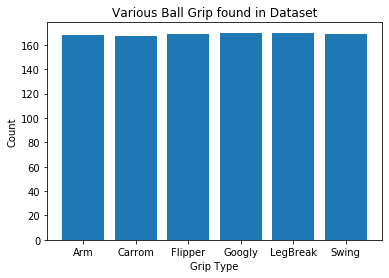

In [49]:
#finding and plotting graph of various GRIPS
unique, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Grip Type")
plt.ylabel("Count")
plt.title("Various Ball Grip found in Dataset")
plt.show()

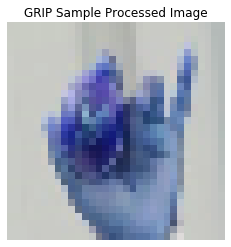

In [50]:
#shuffling and normalizing the dataset
X = X.astype('float32')
X = X/255 #normalizing pixel
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shffling images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)

#now plot sample processed messidor image
processed_image = X[3]
plt.imshow(processed_image)
plt.title('GRIP Sample Processed Image')
plt.axis('off')
plt.show()

In [51]:
#dataset train and test split details
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and tesrt
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("(80%) Grip images used for training : "+str(X_train.shape[0])) #print training and test size
print("(20%) Grip images used for testing  : "+str(X_test.shape[0]))

Dataset train & test split as 80% dataset for training and 20% for testing
(80%) Grip images used for training : 810
(20%) Grip images used for testing  : 203


In [52]:
#defining global features to store accuracy and other values
accuracy = []
precision = []
recall = [] 
fscore = []

In [53]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()     

CNN Accuracy  : 95.07389162561576
CNN Precision : 95.40764790764791
CNN Recall    : 95.13874555670222
CNN FSCORE    : 94.98367106941922


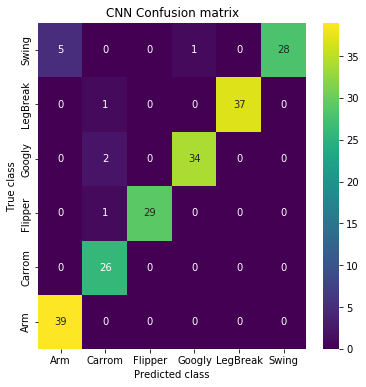

In [54]:
#now training CNN algorithm on GRIP dataset and evaluating its performnace in terms of accuracy, precision, recall 
cnn_model = Sequential()
#defining input shape layer
cnn_model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
#defining CNN layer with 25 filters to filter images 25 time3
cnn_model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
cnn_model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
cnn_model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=100, activation='relu'))#definining output layer
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(units=y_train.shape[1], activation='softmax'))#defining prediction layer
#compiling, training and loading model
cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
predict = cnn_model.predict(X_test) #now perform prediction on test images
predict = np.argmax(predict, axis=1)
test_y = np.argmax(y_test, axis=1)
calculateMetrics("CNN", test_y, predict)#call this function to calculate accuracy and other metrics

Alexnet Accuracy  : 96.55172413793103
Alexnet Precision : 96.65032679738563
Alexnet Recall    : 96.7207800799132
Alexnet FSCORE    : 96.55603187220835


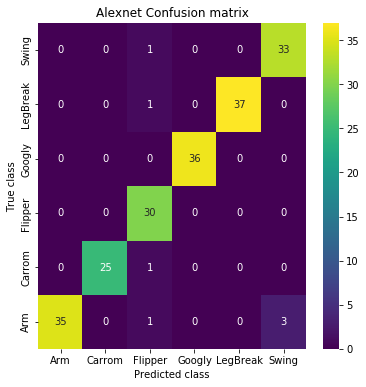

In [55]:
#now training Alexnet Algortihm on 80% training images and 20% testing images
alexnet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])
#compiling, training and loading alexnet model
alexnet_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
if os.path.exists("model/alexnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/alexnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = alexnet_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/alexnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    alexnet_model.load_weights("model/alexnet_weights.hdf5")
predict = alexnet_model.predict(X_test) #now perform prediction on test images
predict = np.argmax(predict, axis=1)
test_y = np.argmax(y_test, axis=1)
calculateMetrics("Alexnet", test_y, predict)#call this function to calculate accuracy and other metrics    

Resnet101 Accuracy  : 99.01477832512316
Resnet101 Precision : 98.96604938271606
Resnet101 Recall    : 99.00584795321637
Resnet101 FSCORE    : 98.96985602913149


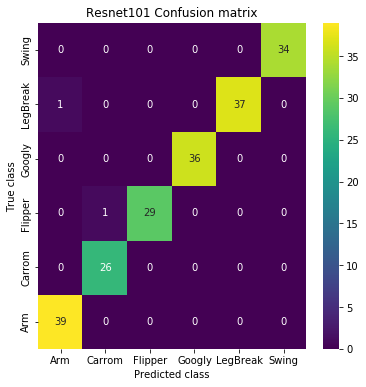

In [56]:
from keras.models import load_model
#now training Resnet101 on 80% training images and tetsiing on 20% test images
#creating Resnet101 object
resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in resnet.layers:
    layer.trainable = False
resnet_model = Sequential()
resnet_model.add(resnet) #adding resnet layer to current CNN object to predict GRIP images
#adding CNN layer with 32 filters to filter images 32 times
resnet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#maxpool layer to collect relevant features from CNN previous layer
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another CNN layer to further filter images
resnet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
#max pool layer to collect relevant features
resnet_model.add(MaxPooling2D(pool_size = (1, 1)))
#flatten to convert multidimension  images to single dimension
resnet_model.add(Flatten())
#defining output layer 
resnet_model.add(Dense(units = 256, activation = 'relu'))
resnet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))#layer to predict images
#now compile, training and loading the model
resnet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/resnet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/resnet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = resnet_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/resnet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    resnet_model = load_model("model/resnet_weights.hdf5")
predict = resnet_model.predict(X_test) #now perform prediction on test images
predict = np.argmax(predict, axis=1)
test_y = np.argmax(y_test, axis=1)
calculateMetrics("Resnet101", test_y, predict)#call this function to calculate accuracy and other metrics     

VGG16 Accuracy  : 98.0295566502463
VGG16 Precision : 97.61904761904762
VGG16 Recall    : 97.69230769230771
VGG16 FSCORE    : 97.61600681140911


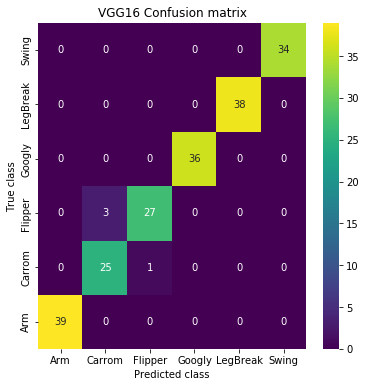

In [57]:
#now training VGG16 on 80% training images and tetsiing on 20% test images
#creating VGG object
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in vgg.layers:
    layer.trainable = False
vgg_model = Sequential()
vgg_model.add(vgg) #adding VGG layer to current CNN object to predict GRIP images
#adding CNN layer with 32 filters to filter images 32 times
vgg_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#maxpool layer to collect relevant features from CNN previous layer
vgg_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another CNN layer to further filter images
vgg_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
#max pool layer to collect relevant features
vgg_model.add(MaxPooling2D(pool_size = (1, 1)))
#flatten to convert multidimension  images to single dimension
vgg_model.add(Flatten())
#defining output layer 
vgg_model.add(Dense(units = 256, activation = 'relu'))
vgg_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))#layer to predict images
#now compile, training and loading the model
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/vgg_weights.hdf5', verbose = 1, save_best_only = True)
    hist = vgg_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/vgg_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    vgg_model.load_weights("model/vgg_weights.hdf5")
predict = vgg_model.predict(X_test) #now perform prediction on test images
predict = np.argmax(predict, axis=1)
test_y = np.argmax(y_test, axis=1)
calculateMetrics("VGG16", test_y, predict)#call this function to calculate accuracy and other metrics     

DenseNet Accuracy  : 57.14285714285714
DenseNet Precision : 66.83697838109603
DenseNet Recall    : 56.2477618127773
DenseNet FSCORE    : 55.37520504177965


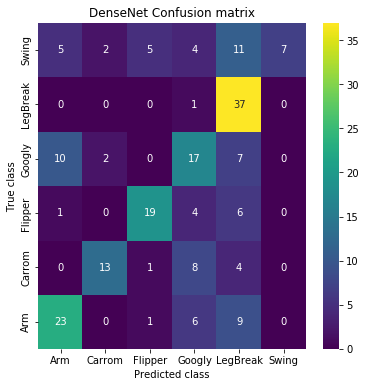

In [58]:
#now training Densenet on 80% training images and tetsiing on 20% test images
#creating DenseNet object
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
for layer in vgg.layers:
    layer.trainable = False
densenet_model = Sequential()
densenet_model.add(densenet) #adding VGG layer to current CNN object to predict GRIP images
#adding CNN layer with 32 filters to filter images 32 times
densenet_model.add(Convolution2D(32, (1, 1), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#maxpool layer to collect relevant features from CNN previous layer
densenet_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another CNN layer to further filter images
densenet_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
#max pool layer to collect relevant features
densenet_model.add(MaxPooling2D(pool_size = (1, 1)))
#flatten to convert multidimension  images to single dimension
densenet_model.add(Flatten())
#defining output layer 
densenet_model.add(Dense(units = 256, activation = 'relu'))
densenet_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))#layer to predict images
#now compile, training and loading the model
densenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/densenet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/densenet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = densenet_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/densenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    densenet_model = load_model("model/densenet_weights.hdf5")
predict = densenet_model.predict(X_test) #now perform prediction on test images
predict = np.argmax(predict, axis=1)
test_y = np.argmax(y_test, axis=1)
calculateMetrics("DenseNet", test_y, predict)#call this function to calculate accuracy and other metrics

In [59]:
#defining function to get LOSS values
def getModelLoss(model_name):
    f = open(model_name, 'rb')
    shrimp = pickle.load(f)
    f.close()
    accuracy = shrimp['val_accuracy']
    loss = shrimp['val_loss']
    return accuracy, loss    

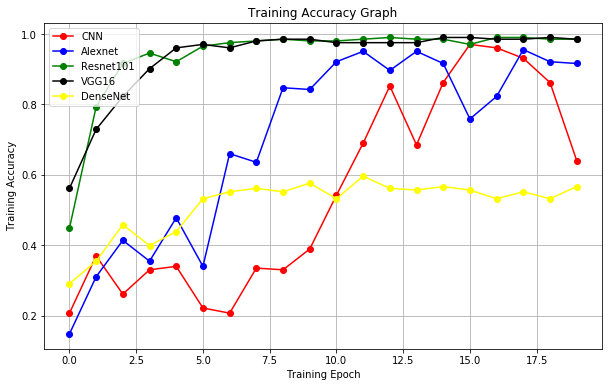

In [60]:
#now plot CNN, Alexnet, Resnet, VGG & DenseNet training accuracy graph
cnn_acc, cnn_loss = getModelLoss("model/cnn_history.pckl")
alexnet_acc, alexnet_loss = getModelLoss("model/alexnet_history.pckl")
resnet_acc, resnet_loss = getModelLoss("model/resnet_history.pckl")
vgg_acc, vgg_loss = getModelLoss("model/vgg_history.pckl")
densenet_acc, densenet_loss = getModelLoss("model/densenet_history.pckl")

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Training Epoch')
plt.ylabel('Training Accuracy')
plt.plot(cnn_acc, 'ro-', color = 'red')
plt.plot(alexnet_acc, 'ro-', color = 'blue')
plt.plot(resnet_acc, 'ro-', color = 'green')
plt.plot(vgg_acc, 'ro-', color = 'black')
plt.plot(densenet_acc, 'ro-', color = 'yellow')
plt.legend(['CNN', 'Alexnet','Resnet101', 'VGG16', 'DenseNet'], loc='upper left')
plt.title('Training Accuracy Graph')
plt.show()

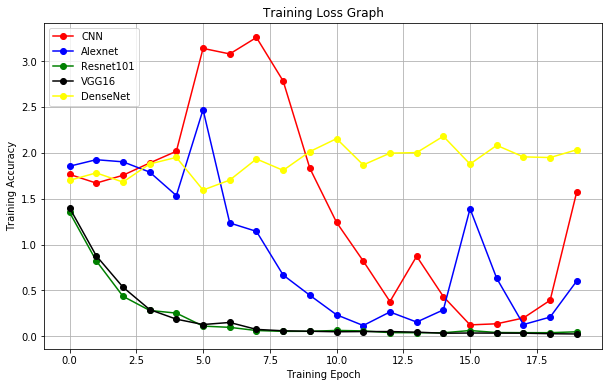

In [61]:
#now plot CNN, Alexnet, Resnet, VGG & DenseNet training loss graph
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Training Epoch')
plt.ylabel('Training Accuracy')
plt.plot(cnn_loss, 'ro-', color = 'red')
plt.plot(alexnet_loss, 'ro-', color = 'blue')
plt.plot(resnet_loss, 'ro-', color = 'green')
plt.plot(vgg_loss, 'ro-', color = 'black')
plt.plot(densenet_loss, 'ro-', color = 'yellow')
plt.legend(['CNN', 'Alexnet','Resnet101', 'VGG16', 'DenseNet'], loc='upper left')
plt.title('Training Loss Graph')
plt.show()

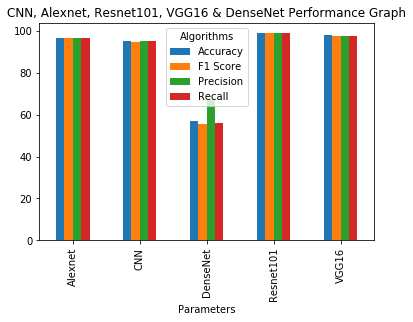

In [63]:
#all algorithms performance comparison Graph
import pandas as pd
df = pd.DataFrame([['CNN','Precision',precision[0]],['CNN','Recall',recall[0]],['CNN','F1 Score',fscore[0]],['CNN','Accuracy',accuracy[0]],
                   ['Alexnet','Precision',precision[1]],['Alexnet','Recall',recall[1]],['Alexnet','F1 Score',fscore[1]],['Alexnet','Accuracy',accuracy[1]],
                   ['Resnet101','Precision',precision[2]],['Resnet101','Recall',recall[2]],['Resnet101','F1 Score',fscore[2]],['Resnet101','Accuracy',accuracy[2]],
                   ['VGG16','Precision',precision[3]],['VGG16','Recall',recall[3]],['VGG16','F1 Score',fscore[3]],['VGG16','Accuracy',accuracy[3]],
                   ['DenseNet','Precision',precision[4]],['DenseNet','Recall',recall[4]],['DenseNet','F1 Score',fscore[4]],['DenseNet','Accuracy',accuracy[4]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("CNN, Alexnet, Resnet101, VGG16 & DenseNet Performance Graph")
plt.show()

In [65]:
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["CNN","Alexnet","Resnet101","VGG16", 'DenseNet']
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
display(temp)

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,CNN,95.407648,95.138746,94.983671,95.073892
1,Alexnet,96.650327,96.720780,96.556032,96.551724
2,Resnet101,98.966049,99.005848,98.969856,99.014778
3,VGG16,97.619048,97.692308,97.616007,98.029557
4,DenseNet,66.836978,56.247762,55.375205,57.142857


In [66]:
#function to predict Grip
def predictGrip(image_path):
    image = cv2.imread(image_path) #read image
    img = cv2.resize(image, (32, 32)) #resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3) #image with 3 colour channel as RGB
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image as float values
    img = img/255 #normalize image pixel
    preds = vgg_model.predict(img) #now predict grip in image
    predict = np.argmax(preds)
    score = np.amax(preds)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))
    #write predited output
    cv2.putText(img, 'Grip Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 255, 240), 2)
    plt.figure(figsize=(8,8))
    plt.imshow(img)

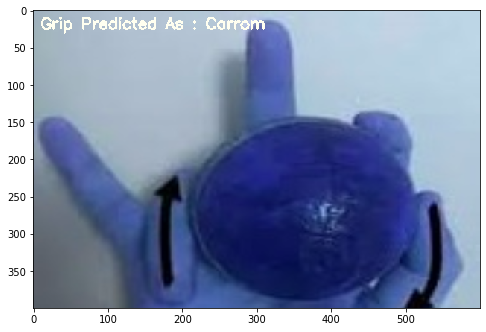

In [67]:
#call predict function with input image to predict grip
predictGrip("testImages/test1.jpg")

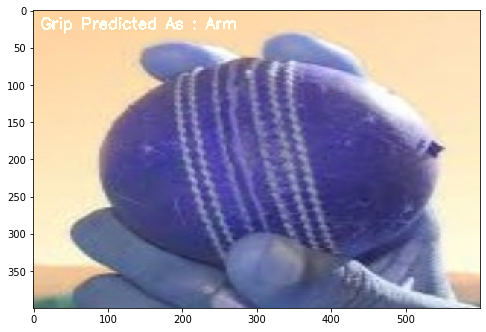

In [68]:
#call predict function with input image to predict grip
predictGrip("testImages/test2.jpg")

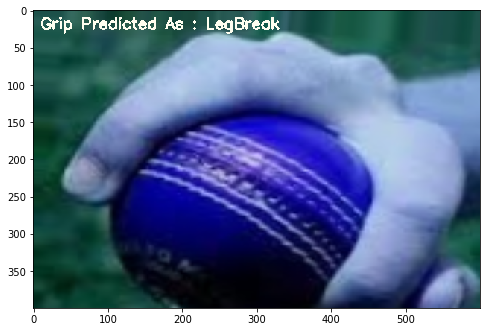

In [69]:
#call predict function with input image to predict grip
predictGrip("testImages/test3.png")

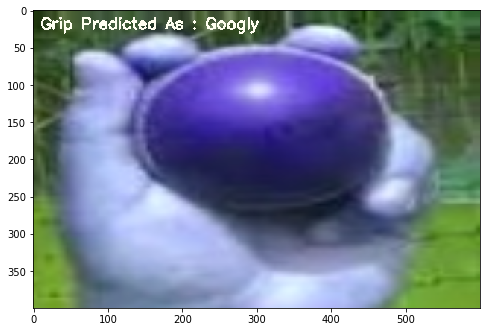

In [70]:
#call predict function with input image to predict grip
predictGrip("testImages/test4.png")

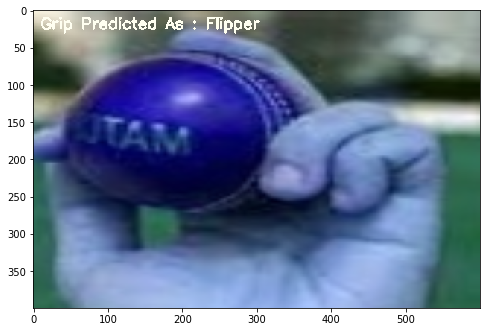

In [71]:
#call predict function with input image to predict grip
predictGrip("testImages/test5.png")

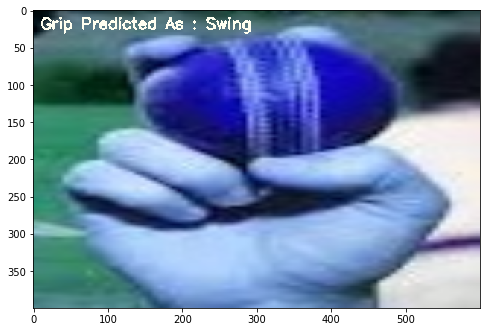

In [72]:
#call predict function with input image to predict grip
predictGrip("testImages/test6.jpg")